## Deskewing through Projection Profile

In [1]:
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
import numpy as np
from skimage.filters import sobel
from skimage.transform import rotate
from skimage.util import invert

# load the image and convert it to grayscale
image = rgb2gray(imread("samples/doc.png"))

def horizontal_projections(sobel_image):
    return np.sum(sobel_image, axis=1)

# find the horizotal projection of the image and get the global 
def get_skew_angle(img):
    sobel_image = invert(sobel(img))
    predicted_angle = 0
    highest_hp = 0
    for index, angle in enumerate(range(-10, 10)):
        hp = horizontal_projections(rotate(sobel_image, angle, cval=1))
        median_hp = np.median(hp)
        if highest_hp < median_hp:
            predicted_angle = angle
            highest_hp = median_hp
            
    # print 'first angle:', predicted_angle
    # this first angle gives me an approximate angle where my actual rotation may be present. I will fine tune this
    # further with a better angle.

    finetuning_range = np.arange(predicted_angle - 1.0, predicted_angle + 1.0, 0.01)
    for index, angle in enumerate(finetuning_range):
        hp = horizontal_projections(rotate(sobel_image, angle, cval=1))
        median_hp = np.median(hp)
        if highest_hp < median_hp:
            predicted_angle = angle
            highest_hp = median_hp
    
    print("predicted angle:", predicted_angle)
    return predicted_angle

fig, ax = plt.subplots(ncols=2, figsize=(20,20))
ax[0].imshow(image, cmap="gray")
ax[1].imshow(rotate(image, get_skew_angle(image), cval=1), cmap="gray")
plt.show()

predicted angle: 2.410000000000001


<Figure size 2000x2000 with 2 Axes>

## Skew correction using Hough Transform

Text(0.5, 1.0, 'Detected lines')

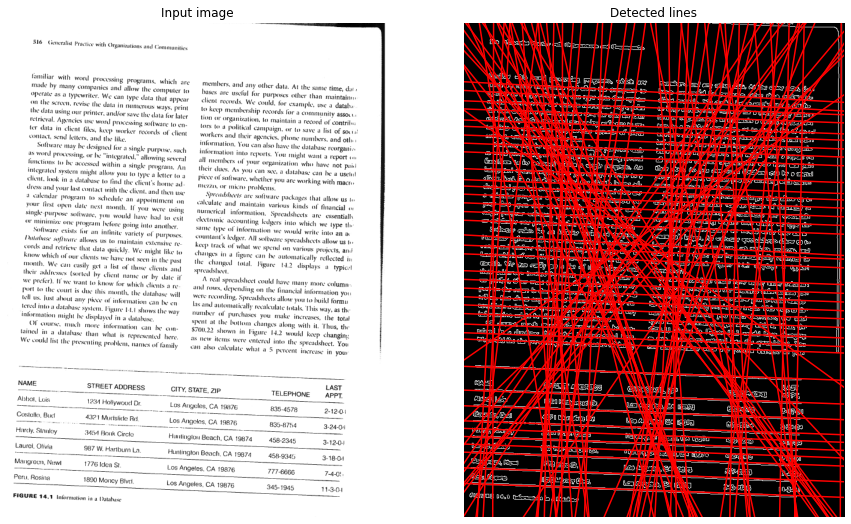

In [2]:
import numpy as np
from skimage.transform import hough_line, hough_line_peaks
from skimage.transform import rotate
from skimage.feature import canny
from skimage.io import imread
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from scipy.stats import mode


edges = canny(image)
# Classic straight-line Hough transform
tested_angles = np.deg2rad(np.arange(0.1, 180.0))
h, theta, d = hough_line(edges, theta=tested_angles)

# Generating figure 1
fig, axes = plt.subplots(1, 2, figsize=(15, 16))
ax = axes.ravel()

ax[0].imshow(image, cmap="gray")
ax[0].set_title('Input image')
ax[0].set_axis_off()

ax[1].imshow(edges, cmap="gray")
origin = np.array((0, image.shape[1]))

for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
    ax[1].plot(origin, (y0, y1), '-r')
    
ax[1].set_xlim(origin)
ax[1].set_ylim((edges.shape[0], 0))
ax[1].set_axis_off()
ax[1].set_title('Detected lines')

[2.24620502]


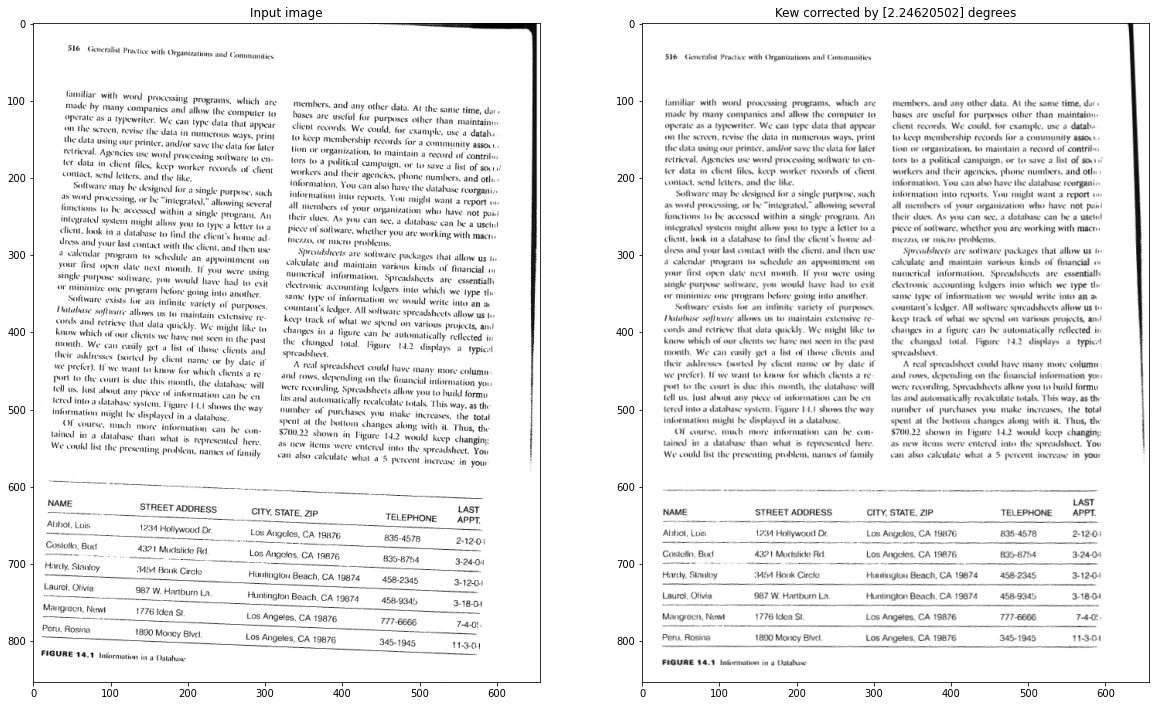

In [3]:
import numpy as np
from skimage.transform import hough_line, hough_line_peaks
from skimage.transform import rotate
from skimage.feature import canny
from skimage.io import imread
from skimage.color import rgb2gray
from scipy.stats import mode

def skew_angle_hough_transform(image):
    # convert to edges
    edges = canny(image)
    # Classic straight-line Hough transform between 0.1 - 180 degrees.
    tested_angles = np.deg2rad(np.arange(0.1, 180.0))
    h, theta, d = hough_line(edges, theta=tested_angles)
    
    # find line peaks and angles
    accum, angles, dists = hough_line_peaks(h, theta, d)
    
    # round the angles to 2 decimal places and find the most common angle.
    most_common_angle = mode(np.around(angles, decimals=2))[0]
    
    # convert the angle to degree for rotation.
    skew_angle = np.rad2deg(most_common_angle - np.pi/2)
    print(skew_angle)
    return skew_angle
    
skew_angle = skew_angle_hough_transform(image)
fig, ax = plt.subplots(ncols=2, figsize=(20,20))
ax[0].imshow(image, cmap="gray")
ax[0].set_title('Input image')
ax[1].imshow(rotate(image, skew_angle, cval=1), cmap="gray")
ax[1].set_title('Kew corrected by '+str(skew_angle)+' degrees')
plt.show()

## Deskewing using Fourier Transform 

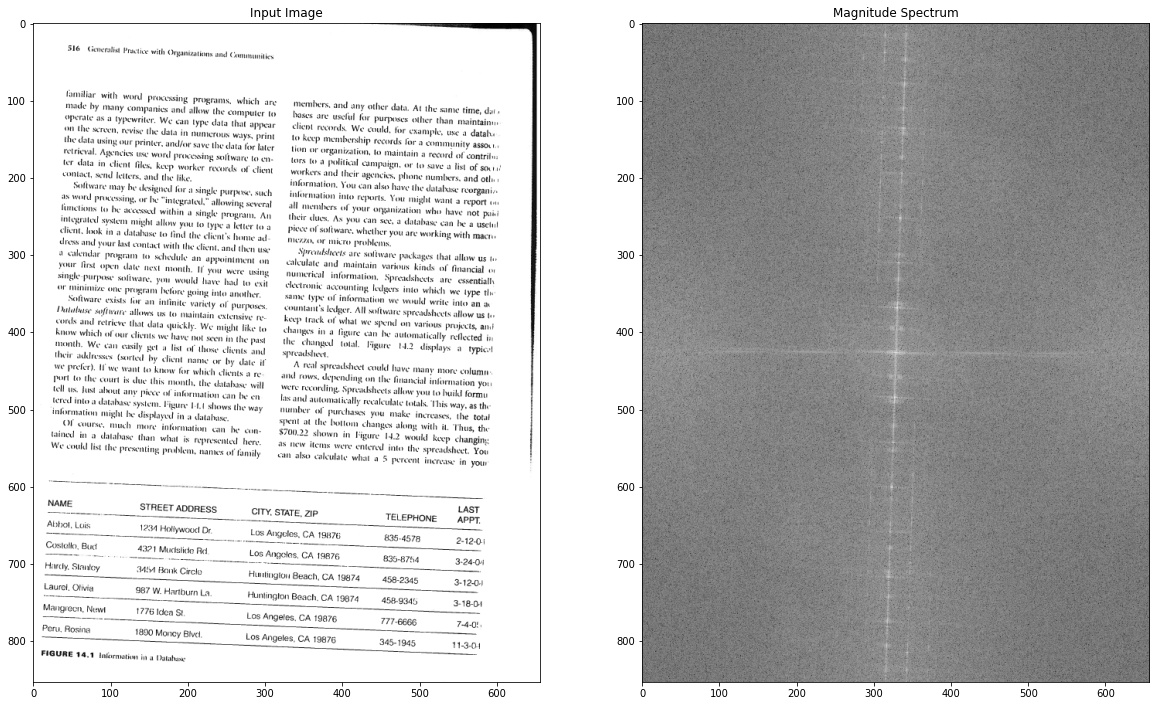

In [4]:
import numpy as np
from matplotlib import pyplot as plt
from skimage import img_as_float, img_as_int

# find the edges in the image
edges = canny(image)

# fourier transform 2d on the edge images
f = np.fft.fft2(edges)

# shift the frequencies to center to see the values
fshift = np.fft.fftshift(f)

# convert into a spectrum for visualization
magnitude_spectrum = np.log(np.abs(fshift))

# plot the images and spectrum
fig, ax = plt.subplots(ncols=2, figsize=(20,20))
ax[0].imshow(image, cmap = 'gray')
ax[0].set_title('Input Image')

ax[1].imshow(magnitude_spectrum, cmap = 'gray')
ax[1].set_title('Magnitude Spectrum')
plt.show()

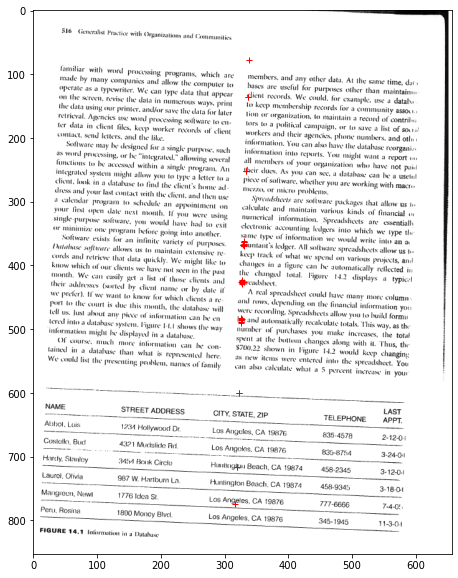

In [6]:
# to find the angle the center line makes with the x axis.

# first remove the center pixel.
r,c = magnitude_spectrum.shape
magnitude_spectrum[int(r/2),int(c/2)] = 0

fig, ax = plt.subplots(figsize=(10,10))

# sort all the frequencies by their value in descending order and pick the top 30 points.
frequency_and_indexes = []
for ri in range(r):
    for ci in range(c):
        frequency_and_indexes.append([magnitude_spectrum[ri][ci], ci, ri])
        
frequency_and_indexes = np.array(frequency_and_indexes)
# sorted by the frequency value. column 0 and take  the last 30 values.
frequency_and_indexes = frequency_and_indexes[frequency_and_indexes[:,0].argsort()[::-1]][:30]

# visualize these top points and see where they lie on the image
for fi in frequency_and_indexes:
    ax.plot(fi[1],fi[2],'+r')
    
ax.imshow(image, cmap="gray")

In [ ]:
from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(frequency_and_indexes[:,1],frequency_and_indexes[:,2])
rotation_angle = np.round(np.rad2deg(np.arctan(slope)-np.pi/2), decimals=2)
fig, ax = plt.subplots(ncols=2, figsize=(20,20))
ax[0].imshow(image, cmap="gray")
ax[0].set_title('Input Image')
ax[1].imshow(rotate(image, rotation_angle, cval=1), cmap="gray")
ax[1].set_title('Image rotated by angle ' + str(rotation_angle)+' degrees')
plt.show()

In [ ]:
from scipy import stats
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
import numpy as np
from skimage.feature import canny
from skimage.transform import rotate

# combining everything together in a single function.
def detect_skew_angle_fourier_tranform(image):
    # find the edges in the image
    edges = canny(image)

    # fourier transform 2d on the edge images
    f = np.fft.fft2(edges)

    # shift the frequencies to center to see the values
    fshift = np.fft.fftshift(f)
    
    # take only the real part from the complex values of fshift.
    magnitude_spectrum = np.log(np.abs(fshift))
    
    # to find the angle the center line makes with the x axis.
    # first remove the center pixel.
    r,c = magnitude_spectrum.shape
    magnitude_spectrum[int(r/2),int(c/2)] = 0
    
    # sort all the frequencies by their value in descending order and pick the top 30 points.
    
    # create pair of frequency, x_index, y_index.
    frequency_and_indexes = []
    for ri in range(r):
        for ci in range(c):
            frequency_and_indexes.append([magnitude_spectrum[ri][ci], ci, ri])

    frequency_and_indexes = np.array(frequency_and_indexes)
    
    # sorted by the frequency value at column 0 and take the last 30 values.
    frequency_and_indexes = frequency_and_indexes[frequency_and_indexes[:,0].argsort()[::-1]][:30]
    
    # find the rotation angle by using the linear regression method.
    slope, intercept, r_value, p_value, std_err = stats.linregress(frequency_and_indexes[:,1],frequency_and_indexes[:,2])
    rotation_angle = np.round(np.rad2deg(np.arctan(slope)-np.pi/2), decimals=2)
    
    return rotation_angle

# image is grayscale
rotation_angle = detect_skew_angle_fourier_tranform(image)
fig, ax = plt.subplots(ncols=2, figsize=(20,20))
ax[0].imshow(image, cmap="gray")
ax[0].set_title('Input Image')
ax[1].imshow(rotate(image, rotation_angle, cval=1), cmap="gray")
ax[1].set_title('Image rotated by angle ' + str(rotation_angle)+' degrees')
plt.show()